https://www.kaggle.com/c/bike-sharing-demand/data?select=train.csv

# 자전거 대여량 예측 모델 

In [120]:
# LinearRegression,RandomForestRegressor
# GradientBoostingRegressor, XGBRegressor, LGBMRegressor

datetime - 년-월-일-24시간   
season -  1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울   
holiday - 해당 요일이 휴일인지 여부. 0 = 평일(no), 1 = 휴일(휴)     
workingday - 해당 요일이 주말이나 휴일이 아닌지 여부. 0 = 휴일(no), 1 = 평일(일)    
weather - 1: 맑음, 구름 약간, 부분적으로 구름, 부분적으로 구름   
2: 안개 + 구름, 안개 + 깨진 구름, 안개 + 구름 약간, 안개   
3: 가벼운 눈, 가벼운 비 + 뇌우 + 흩어진 구름, 가벼운 비 + 흩어진 구름   
4: 폭우 + 얼음판 + 뇌우 + 안개, 눈 + 안개    
temp - 섭씨 온도   
atemp - 체감 온도   
섭씨 humid - 상대 습도   
windspeed - 풍속    

casual - 등록된 사용자가 시작한 대여 수   
registered - 등록된 사용자가 시작한 대여 수   
count - 총 대여 수 

<br/>
<br/>

# 라이브러리 불러오기

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

<br/>
<br/>

# 데이터 확인
- 결측치 확인
- 이상치 확인
- 제거
- 상관관계 분석

In [122]:
df_train = pd.read_csv('bike-sharing-demand/train.csv')

In [123]:
df_train.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [124]:
# 각 컬럼의 결측치 개수 확인
print(df_train.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [125]:
# 이상치를 탐지할 수치형 피처 목록
# casual과 registered는 count를 구성하는 변수이므로 포함합니다.
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']

# 각 피처에 대해 이상치 탐지 및 제거
for col in numerical_features:
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # 이상치 경계 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치를 벗어나는 행의 개수 출력
    outlier_count = np.sum((df_train[col] < lower_bound) | (df_train[col] > upper_bound))
    print(f"'{col}' 컬럼의 이상치 개수: {outlier_count}개")
    
    # 이상치를 제거하고 데이터프레임 업데이트
    df_new = df_train[(df_train[col] >= lower_bound) & (df_train[col] <= upper_bound)]

'temp' 컬럼의 이상치 개수: 0개
'atemp' 컬럼의 이상치 개수: 0개
'humidity' 컬럼의 이상치 개수: 22개
'windspeed' 컬럼의 이상치 개수: 227개


In [126]:
print("\n 이상치 제거 후")
print("원본 데이터프레임 shape:", df_train.shape)
print("이상치 제거 후 데이터프레임 shape:", df_new.shape)


 이상치 제거 후
원본 데이터프레임 shape: (10886, 12)
이상치 제거 후 데이터프레임 shape: (10659, 12)


In [127]:
df_new.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\2798349113.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\2798349113.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\2798349113.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\2798349113.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(

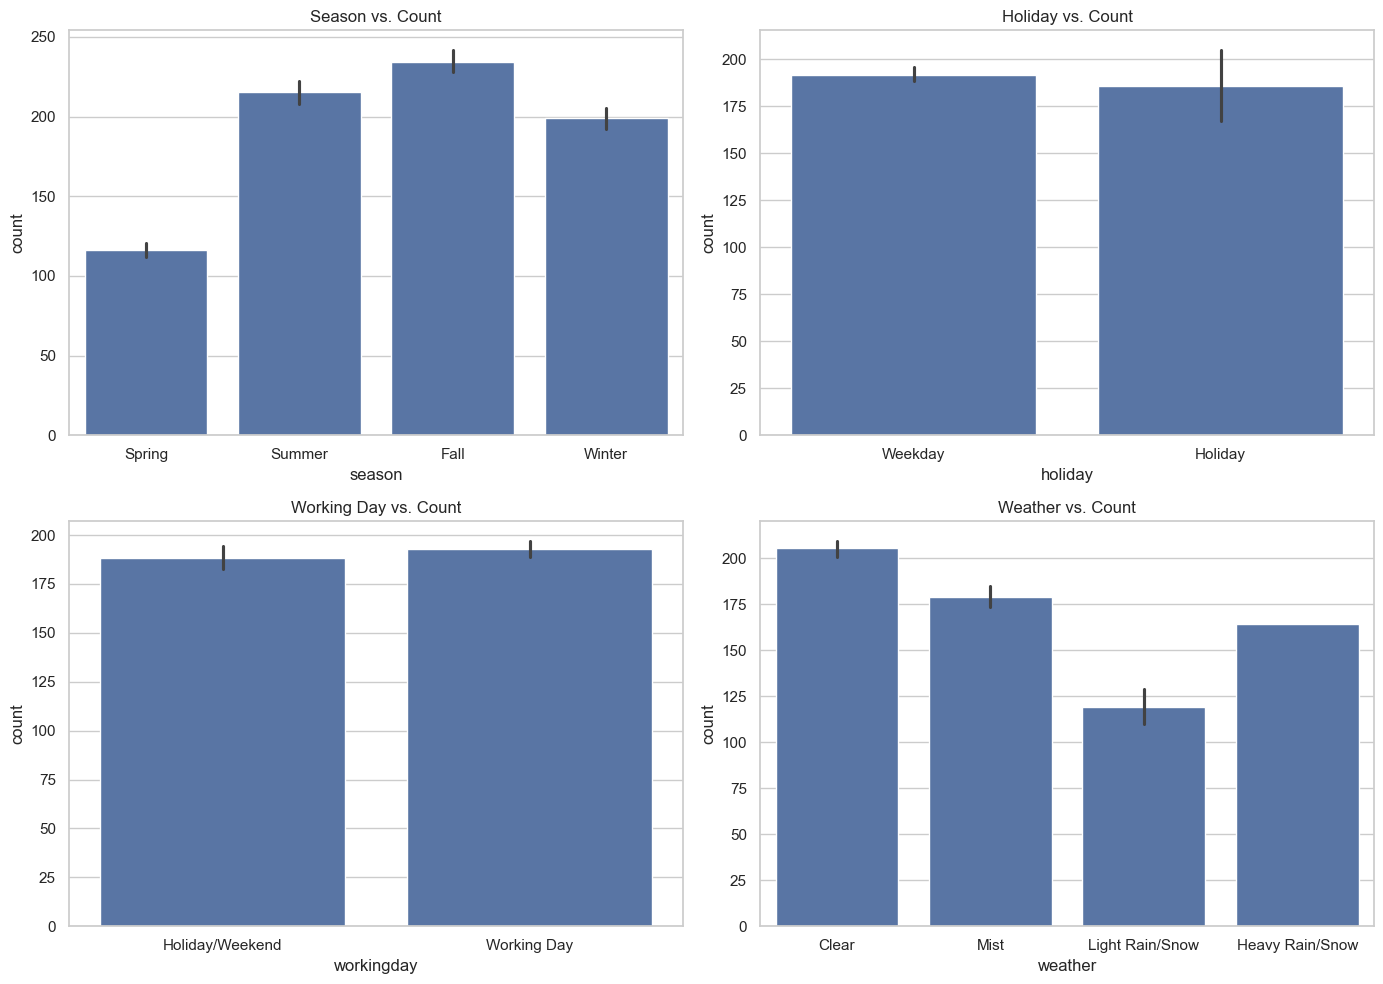

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 스타일 설정
sns.set(style="whitegrid")

# season, holiday, workingday, weather 별 count 평균 막대그래프
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.barplot(data=df_train, x="season", y="count", ax=axes[0, 0])
axes[0, 0].set_title('Season vs. Count')
axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])

sns.barplot(data=df_train, x="holiday", y="count", ax=axes[0, 1])
axes[0, 1].set_title('Holiday vs. Count')
axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])

sns.barplot(data=df_train, x="workingday", y="count", ax=axes[1, 0])
axes[1, 0].set_title('Working Day vs. Count')
axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])

sns.barplot(data=df_train, x="weather", y="count", ax=axes[1, 1])
axes[1, 1].set_title('Weather vs. Count')
axes[1, 1].set_xticklabels(['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow'])

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1726494382.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1726494382.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1726494382.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1726494382.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(

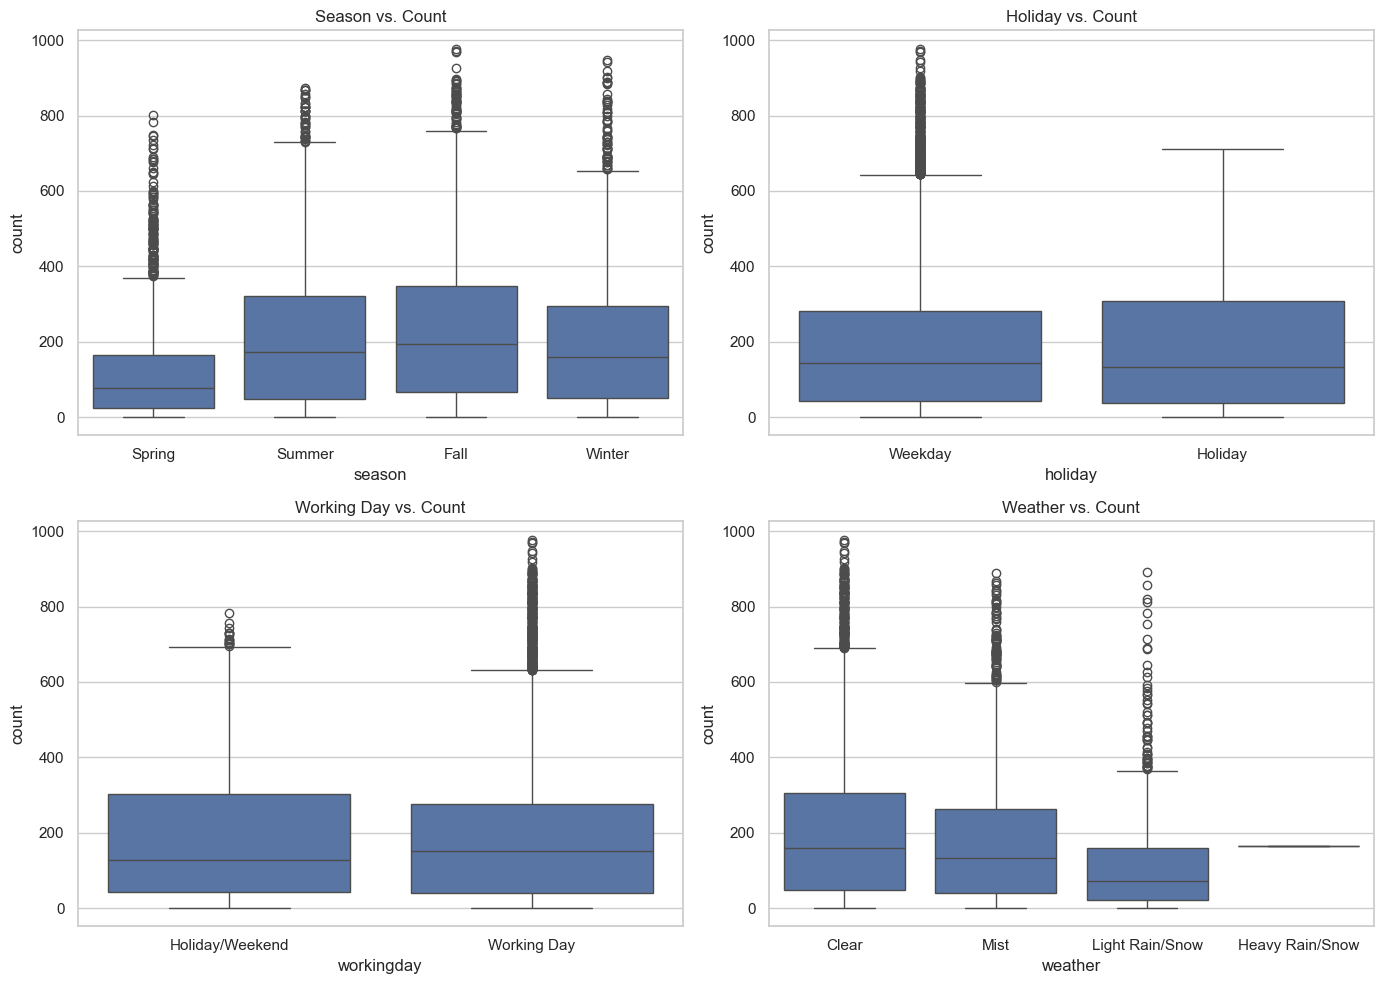

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 스타일 설정
sns.set(style="whitegrid")

# season, holiday, workingday, weather 별 count Boxplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(data=df_train, x="season", y="count", ax=axes[0, 0])
axes[0, 0].set_title('Season vs. Count')
axes[0, 0].set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])

sns.boxplot(data=df_train, x="holiday", y="count", ax=axes[0, 1])
axes[0, 1].set_title('Holiday vs. Count')
axes[0, 1].set_xticklabels(['Weekday', 'Holiday'])

sns.boxplot(data=df_train, x="workingday", y="count", ax=axes[1, 0])
axes[1, 0].set_title('Working Day vs. Count')
axes[1, 0].set_xticklabels(['Holiday/Weekend', 'Working Day'])

sns.boxplot(data=df_train, x="weather", y="count", ax=axes[1, 1])
axes[1, 1].set_title('Weather vs. Count')
axes[1, 1].set_xticklabels(['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow'])

plt.tight_layout()
plt.show()


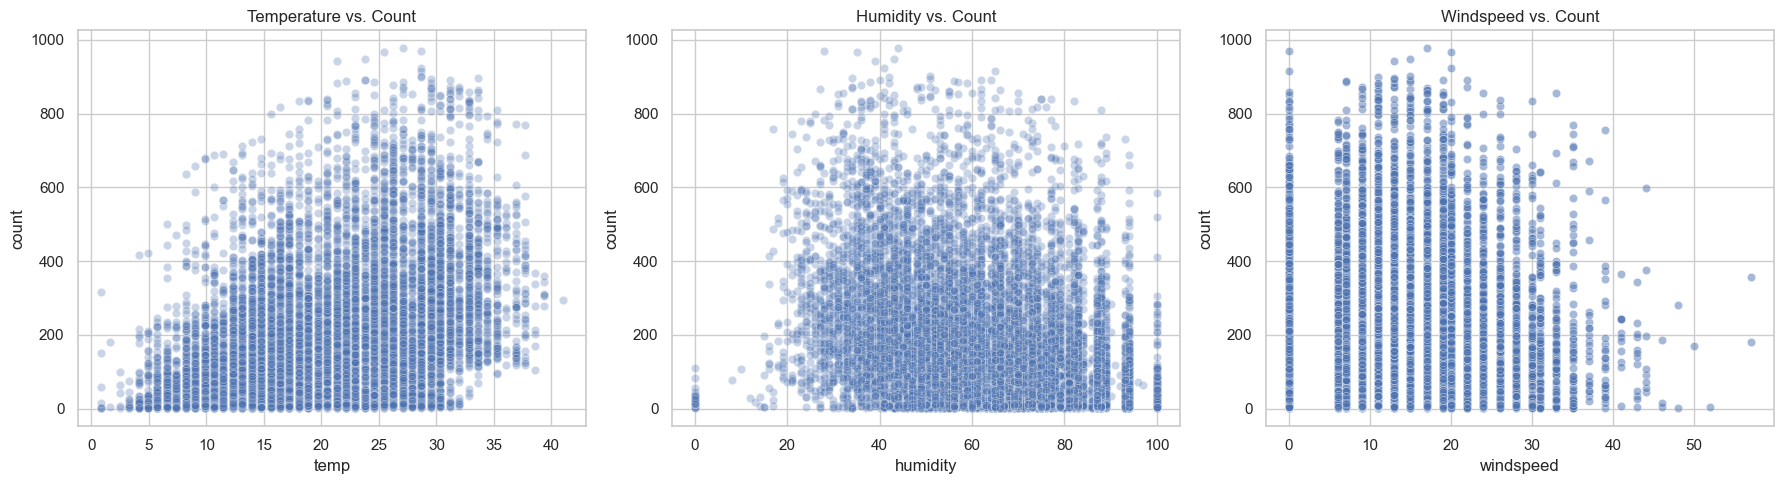

In [130]:
# temp, humidity, windspeed 별 count 산점도
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df_train, x="temp", y="count", ax=axes[0], alpha=0.3)
axes[0].set_title('Temperature vs. Count')

sns.scatterplot(data=df_train, x="humidity", y="count", ax=axes[1], alpha=0.3)
axes[1].set_title('Humidity vs. Count')

sns.scatterplot(data=df_train, x="windspeed", y="count", ax=axes[2], alpha=0.5)
axes[2].set_title('Windspeed vs. Count')

plt.tight_layout()
plt.show()

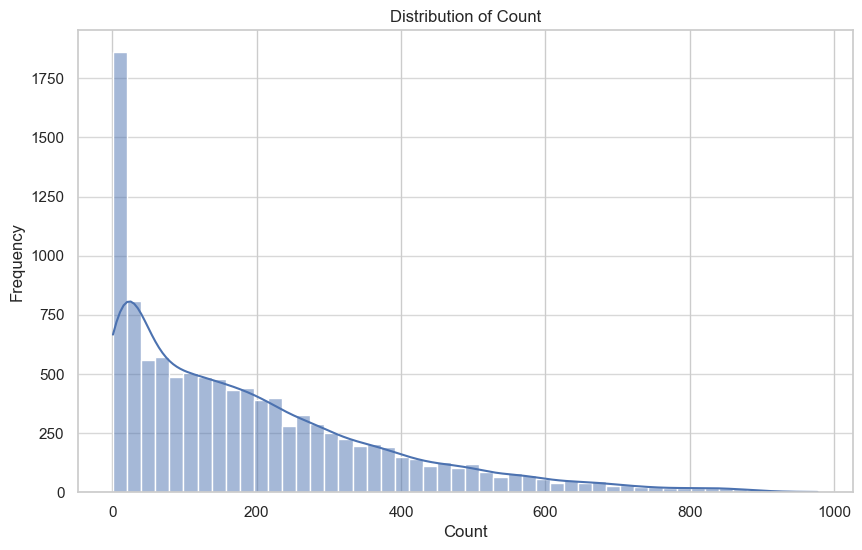

In [131]:
# 'count' 컬럼의 히스토그램 그리기
plt.figure(figsize=(10, 6)) # 그래프 크기 설정
sns.histplot(df_train['count'], bins=50, kde=True) # bins는 막대 개수, kde=True는 밀도 추정 곡선 추가
plt.title('Distribution of Count') # 그래프 제목
plt.xlabel('Count') # x축 레이블
plt.ylabel('Frequency') # y축 레이블
plt.grid(axis='y', alpha=0.75) # y축에 그리드 추가
plt.show() # 그래프 보여주기

강한 오른쪽 꼬리
값이 낮은 구간에 집중되어 있음을 의미한다.
분포의 비대칭성을 고려해서 로그 변환이 필요할 것 같다.(분포가 정규분포에 더 가까워지기 위해서)

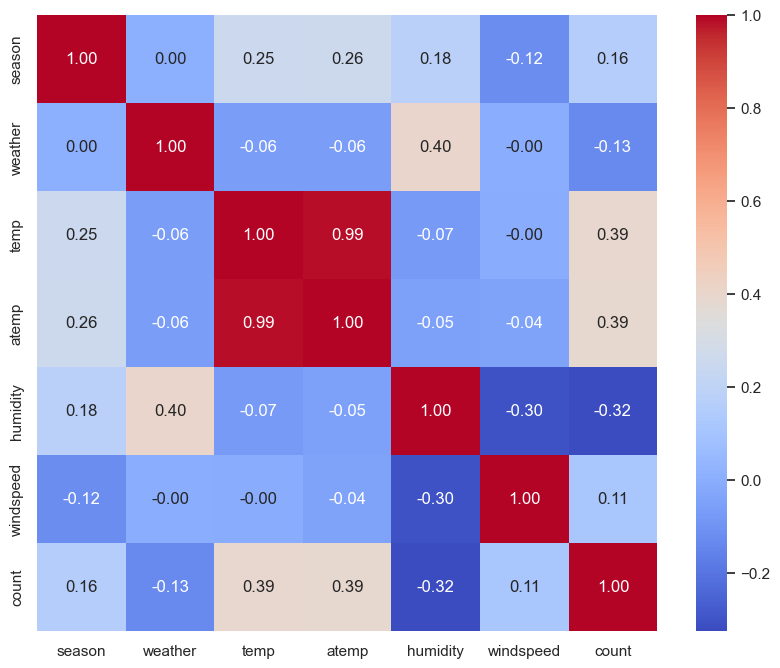

In [132]:
corr = df_new[['season','weather','temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

temp는 atemp와 비슷하다.

<br/>
<br/>

# 데이터 전처리

In [133]:
# 날짜 생성
df_new['date'] = df_new['datetime'].apply(lambda x: x.split()[0])
# 연도 생성
df_new['year'] = df_new['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 생성
df_new['month'] = df_new['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 생성
df_new['hour'] = df_new['datetime'].apply(lambda x: x.split()[1].split(':')[0])

C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1207167441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['date'] = df_new['datetime'].apply(lambda x: x.split()[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1207167441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['year'] = df_new['datetime'].apply(lambda x: x.split()[0].split('-')[0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1207167441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [134]:
df_new

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,22


In [135]:
df_new['log_count'] = np.log1p(df_new['count'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_12980\1739951696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['log_count'] = np.log1p(df_new['count'])


In [136]:
df_new = df_new.drop(columns=['datetime', 'casual', 'registered', 'count', 'date', 'windspeed'])

<br/>
<br/>

# 모델 만들기

데이터 나누기

In [137]:
X = df_new.drop('log_count', axis=1)
y = np.log1p(df_new['log_count'])
df_new.shape

(10659, 11)

스케일러 객체 생성

In [138]:
df_new = df_new.copy()
# 스케일링할 컬럼 선택
cols_to_scale = ['temp','atemp','humidity'] 

scaler = StandardScaler()
df_new[cols_to_scale] = scaler.fit_transform(df_new[cols_to_scale])

In [139]:
df_new.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,month,hour,log_count
0,1,0,0,1,-1.339086,-1.103724,0.984434,2011,01,00,2.833213
1,1,0,0,1,-1.444375,-1.193741,0.932031,2011,01,01,3.713572
2,1,0,0,1,-1.444375,-1.193741,0.932031,2011,01,02,3.496508
3,1,0,0,1,-1.339086,-1.103724,0.670013,2011,01,03,2.639057
4,1,0,0,1,-1.339086,-1.103724,0.670013,2011,01,04,0.693147


선형 회귀 모델 만들고 학습, 예측

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=156)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred[:3]

array([1.50155243, 1.47614786, 1.34694496])

MSE (Mean Squared Error, 평균제곱오차)   
RMSE (Root Mean Squared Error, 평균제곱근오차)   
결정계수 R2

In [141]:
# 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'MSE : {mse}\nRMSE : {rmse}\nR2:{r2}')

MSE : 0.05353497427251727
RMSE : 0.23137626125537872
R2:0.45447504865868715


회귀식   
 lr.intercept_ : 절편
 lr.coef_ : 각 변수의 계수

 b (intercept_): 절편, 모든 입력값이 0일 때 y의 예측값.

w_i (coef_): 각 입력 변수의 계수(기울기), 입력 변수 x_i가 y에 미치는 영향력.

In [142]:
# 회귀식 
# W1, W0
lr.intercept_, lr.coef_

(np.float64(-162.9281664727032),
 array([-0.00027861, -0.01877294, -0.0275021 ,  0.00657929,  0.00431589,
         0.00436973, -0.00285278,  0.08166777,  0.01207516,  0.02179656]))

In [143]:
np.round(lr.intercept_, 1), np.round(lr.coef_,1)

(np.float64(-162.9),
 array([-0. , -0. , -0. ,  0. ,  0. ,  0. , -0. ,  0.1,  0. ,  0. ]))

각 특성(컬럼)과 목표 변수의 관계 확인   

값이 클수록 y(목표 변수)에 큰 영향을 미침.

양수(+) 계수: 해당 변수가 커지면 y도 증가.

음수(-) 계수: 해당 변수가 커지면 y는 감소.

In [144]:
pd.Series(data = np.round(lr.coef_,3), 
          index=df_new.drop('log_count', axis=1).columns).sort_values(ascending=False)

year          0.082
hour          0.022
month         0.012
weather       0.007
temp          0.004
atemp         0.004
season       -0.000
humidity     -0.003
holiday      -0.019
workingday   -0.028
dtype: float64

year, season, hour, workingday,holiday 관계가 크다.

교차검증

In [145]:
from sklearn.model_selection import cross_val_score
neg_mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=5)
neg_mse_scores

array([-0.07210391, -0.04255617, -0.06517652, -0.05043398, -0.0431846 ])

In [146]:
# MSE, RMSE
RMSE = np.sqrt(neg_mse_scores*-1)
np.mean(RMSE), np.round(RMSE)

(np.float64(0.2324988520226597), array([0., 0., 0., 0., 0.]))

In [147]:
#R2
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=5)
r2 = np.mean(r2_scores)
print(f'R2_mean : {r2}')

R2_mean : 0.40709130055753856


--- 

<br/>
<br/>

# 모델 만들기

In [148]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

다항 회귀 모델

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=156)
model_poly = Pipeline([
  ('poly', PolynomialFeatures(degree=3, include_bias=False)),
  ('linear', LinearRegression())]
)
model_poly.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('linear', LinearRegression())])

In [150]:
pred_poly = model_poly.predict(X_test)
mean_squared_error(y_test, pred_poly)

np.float64(0.035279748991729205)

In [151]:
r2_score(y_test, pred_poly)

np.float64(0.6404970094115292)

In [152]:
results = []
best_r2=-np.inf
best_model = None
best_pred = None

for degree in range(1,5):
  model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
    ('linear', LinearRegression())]
  )
  model_poly.fit(X_train, y_train)
  pred_poly = model_poly.predict(X_test)
  mse = mean_squared_error(y_test, pred_poly)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, pred_poly)
  
  results.append({ 'degree':degree,
                  'MSE':mse,
                  'RMSE':rmse,
                  'R2': r2})
  if r2> best_r2:
    best_r2 = r2
    best_model = model_poly
    best_pred = pred_poly
    
pd.DataFrame(results)

,degree,MSE,RMSE,R2
0,1,0.053535,0.231376,0.454475
1,2,0.040674,0.201677,0.585534
2,3,0.035280,0.187829,0.640497
3,4,0.036171,0.190186,0.631420


In [153]:
best_model.named_steps['poly'].degree

3

규제 회귀 모델
- Ridge
- Losso
- ElasticNet

In [154]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

Ridge: alpha = 1.0

In [155]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)

mse = mean_squared_error(y_test, pred_ridge)
rmse = np.sqrt(mse)  
r2 = r2_score(y_test, pred_ridge)

print("\n[Ridge]")
print(f'MSE : {mse:.4f}\nRMSE : {rmse:.4f}\nR2 : {r2:.4f}')


[Ridge]
MSE : 0.0535
RMSE : 0.2314
R2 : 0.4545


In [156]:
from sklearn.linear_model import RidgeCV, LassoCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

In [157]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)
pred_ridge = ridge_cv.predict(X_test)

ridge_mse = mean_squared_error(y_test, pred_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, pred_ridge)

print(f"\n[Ridge_CV]\n최적 alpha: {ridge_cv.alpha_}")
print(f'MSE: {ridge_mse:.4f}\nRMSE: {ridge_rmse:.4f}\nR2: {ridge_r2:.4f}')


[Ridge_CV]
최적 alpha: 100.0
MSE: 0.0535
RMSE: 0.2313
R2: 0.4546


In [158]:
ridge_cv.coef_

array([-4.93204353e-06, -1.16552259e-02, -2.53073816e-02,  6.38804392e-03,
        4.28747235e-03,  4.40578728e-03, -2.86030459e-03,  7.74687558e-02,
        1.19771310e-02,  2.17789809e-02])

Lasso : alpha = 0.1

In [159]:
lasso = Lasso(alpha=0.1)  # alpha 값 작으면 규제 약해짐
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)

print("\n[라쏘 회귀]")
print("MSE:", mean_squared_error(y_test, pred_lasso))
print("RMSE:",np.sqrt(mean_squared_error(y_test, pred_lasso)))
print("R2:", r2_score(y_test, pred_lasso))


[라쏘 회귀]
MSE: 0.05634444710080507
RMSE: 0.23736985297380345
R2: 0.4258463335285626


LassoCV

In [160]:
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
pred_lasso = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, pred_lasso)

In [161]:
print(f"[Lasso_CV]\n최적 alpha: {lasso_cv.alpha_}")
print(f"MSE: {lasso_mse:.3f}\nRMSE: {lasso_rmse:.3f}\nR2: {lasso_r2:.3f}")

[Lasso_CV]
최적 alpha: 0.001
MSE: 0.054
RMSE: 0.231
R2: 0.455


ElasticNet

In [162]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train, y_train)
enet_pred = enet.predict(X_test)
print("\n[엘라스틱넷 회귀]")
print("MSE:", mean_squared_error(y_test, enet_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, enet_pred)))
print("R2:", r2_score(y_test, enet_pred))


[엘라스틱넷 회귀]
MSE: 0.0553471497633539
RMSE: 0.23525974956068005
R2: 0.4360088597813335


모델 성능 비교

In [163]:
results = pd.DataFrame({
  '모델' : ['다항회귀', '릿지회귀', '라쏘회귀', '엘라스틱넷회귀'],
    'MSE': [ mean_squared_error(y_test, pred_poly),
            mean_squared_error(y_test, pred_ridge),
            mean_squared_error(y_test, pred_lasso),
            mean_squared_error(y_test, enet_pred),
        ],
    'RMSE': [ mean_squared_error(y_test, pred_poly),
            mean_squared_error(y_test, pred_ridge),
            mean_squared_error(y_test, pred_lasso),
            mean_squared_error(y_test, enet_pred),
        ],
    'R2': [r2_score(y_test, best_pred),
            r2_score(y_test, pred_ridge),
            r2_score(y_test, pred_lasso),
            r2_score(y_test, enet_pred),
  ]
})
results

,모델,MSE,RMSE,R2
0,다항회귀,0.036171,0.036171,0.640497
1,릿지회귀,0.053520,0.053520,0.454631
2,라쏘회귀,0.053514,0.053514,0.454690
3,엘라스틱넷회귀,0.055347,0.055347,0.436009
